In [80]:
import scipy.io
import os
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import torch
import pytorch_lightning as ptl
from weatherGan.models.Gseg import Gseg
import torchmetrics
import torchvision
from weatherGan.dataloader.dataset import ImageDataset
from weatherGan.models.WeatherGan import WeatherGan
from weatherGan.models.Ginit import Ginit
from weatherGan.models.Discriminators import Expert, WeatherDiscriminator


In [85]:
true_img = torch.load('image_callbacks/true_image_2100_new.pt')

FileNotFoundError: [Errno 2] No such file or directory: 'image_callbacks/true_image_2100_new.pt'

In [86]:
img = torch.load('image_callbacks/image_gen_1800_n.pt')
def print_image(tensor):
    np_img = tensor.detach().permute(1,2,0).cpu().numpy()
    plt.imshow(np_img )
    

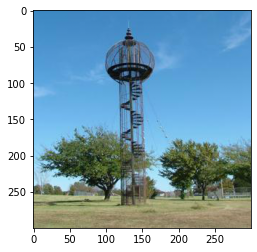

In [84]:
print_image(true_img[2])

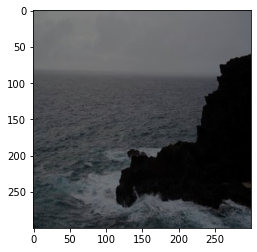

In [77]:
print_image(img[2])

In [31]:
du = WeatherDiscriminator()

In [32]:
du.to(0)

WeatherDiscriminator(
  (featureExtractor): FeatureExtractor(
    (convBlock1): ConvBlock(
      (conv): Conv2d(3, 3, kernel_size=(32, 32), stride=(2, 2), padding=(1, 1))
      (activation): ReLU()
      (pool): MaxPool2d(kernel_size=(2, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
      (layernorm): LayerNorm((3, 135, 135), eps=1e-05, elementwise_affine=True)
    )
    (convBlock2): ConvBlock(
      (conv): Conv2d(3, 3, kernel_size=(32, 32), stride=(2, 2), padding=(1, 1))
      (activation): ReLU()
      (pool): MaxPool2d(kernel_size=(2, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
      (layernorm): LayerNorm((3, 52, 52), eps=1e-05, elementwise_affine=True)
    )
    (convBlock3): ConvBlock(
      (conv): Conv2d(3, 3, kernel_size=(32, 32), stride=(2, 2), padding=(1, 1))
      (activation): ReLU()
      (pool): MaxPool2d(kernel_size=(2, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
      (layernorm): LayerNorm((3, 11, 11), eps=1e-05, elementwise_affine=True)


In [3]:
PATH = 'datasets/dataset/'
train_dataset = ImageDataset(data_dir=PATH,transform= lambda x : x/255,target_transform= lambda x : torch.nn.functional.one_hot( torch.tensor(int(x)), 2)
)

  0%|          | 0/8000 [00:00<?, ?it/s]

In [15]:
gseg = Gseg(num_classes=6)

In [16]:
gseg.to(0)

Gseg(
  (feature_extractor): MobileNetV2(
    (features): Sequential(
      (0): ConvBNActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), str

In [11]:
#This is our Gan, we already pretrained the segmentator and the weather classifier
#we freeze all weights except those of the generator and the expert
model = WeatherGan(num_classes_segmentation=6,num_classes_weather=2,noise_size=32,
         weather_discr_ckpt='checkpoints/weatherClassifier/epoch=9-step=2499.ckpt',segmentator_ckpt='checkpoints/segmentator/last_seg_ckpt.ckpt' ).double()


In [4]:
imgs, segs = train_dataset.imgs, train_dataset.segs

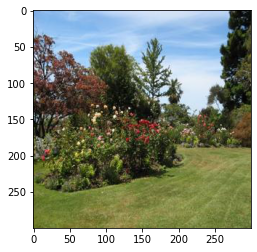

In [5]:
#example of sunny pictures
plt.imshow(imgs[0])

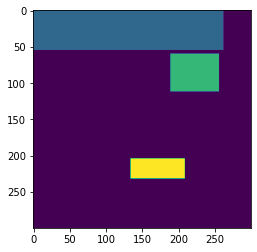

In [9]:
#corresponding weather cues
plt.imshow(segs[0])

In [ ]:
val_dataset = CustomImageDataset(data_dir=PATH,mode='test',transform= lambda x : x/255,target_transform= lambda x : torch.nn.functional.one_hot( torch.tensor(int(x)), 2)
)

In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size = 8,num_workers=8,shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 8,num_workers=8,shuffle = False)

In [ ]:
def compute_class_weights(dataset):
    weights_ones, weights_zeros = [], []
    for _, seg, _, _ in dataset:
        num_ones = sum(seg.numpy()>0)
        num_zeros = 300**2 - num_ones
        weight_ones = 300**2/(2*num_ones)
        weight_zeros = 300**2/(2*num_zeros)
        weights_ones.append(weight_ones)
        weights_zeros.append(weight_zeros)
    return np.mean(weight_ones), np.mean(weight_zeros)

In [ ]:
trainer.save_checkpoint('checkpoints/segmentator/last_seg_ckpt.ckpt')

In [26]:
ones ,zeros = compute_class_weights(train_dataset)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [27]:
class Segmentator(ptl.LightningModule):
    def __init__(self,num_labels=6,lr=2e-5,train_features_extractor=False,**kwargs):
        super(Segmentator,self).__init__()
        self.num_labels = num_labels
        self.lr = lr
        self.gseg = Gseg(num_classes=num_labels,train_features_extractor=train_features_extractor)
        self.ce = torch.nn.CrossEntropyLoss()
        self.acc = torchmetrics.functional.accuracy
        self.f1 = torchmetrics.functional.f1
        self.rec = torchmetrics.functional.recall
        self.prec = torchmetrics.functional.precision
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(lr=self.lr,params=self.parameters() )
        lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer,gamma=0.75)
        return [optimizer], [lr_scheduler]
    def forward(self,image):
        pred = self.gseg(image)
        return pred 
    
    def training_step(self,batch, batch_idx):
        image, seg, _, _ = batch
        batch_size, _, h, w = image.shape
        prediction = self(image)
        flat_pred, flat_seg = prediction.flatten(0,-2).double(),seg.flatten(0,-1).long()
        loss = self.ce(flat_pred, flat_seg)
        accuracy = self.acc(flat_pred, flat_seg,average='macro',num_classes=6)
        recall = self.rec(flat_pred,flat_seg,average='macro',num_classes=6)
        precision = self.prec(flat_pred,flat_seg,average='macro',num_classes=6)
        f1 = self.f1(flat_pred,flat_seg,average='macro',num_classes=6)
        self.log("loss",loss,prog_bar=True,on_step=True)
        self.log("recall",recall,prog_bar=True,on_step=True)
        self.log("precision",precision,prog_bar=True,on_step=True)
        self.log("f1",f1,prog_bar=True,on_step=True)
        
        self.log("accuracy", accuracy, prog_bar=True,on_step = True)
        return loss
    def validation_step(self,batch, batch_idx):
        image, seg, _, _ = batch
        batch_size, _, h, w = image.shape
        prediction = self(image)
        flat_pred, flat_seg = prediction.flatten(0,-2).double(),seg.flatten(0,-1).long()
        loss = self.ce(flat_pred, flat_seg)
        accuracy = self.acc(flat_pred, flat_seg,average='macro',num_classes=6)
        recall = self.rec(flat_pred,flat_seg,average='macro',num_classes=6)
        precision = self.prec(flat_pred,flat_seg,average='macro',num_classes=6)
        f1 = self.f1(flat_pred,flat_seg,average='macro',num_classes=6)
        self.log("val_loss",loss,prog_bar=True,on_step=True)
        self.log("val_recall",recall,prog_bar=True,on_step=True)
        self.log("val_precision",precision,prog_bar=True,on_step=True)
        self.log("val_f1",f1,prog_bar=True,on_step=True)
        self.log("val_accuracy", accuracy, prog_bar=True,on_step = True)
        return loss
    def test_step(self,batch, batch_idx):
        image, seg, _, _ = batch
        batch_size, _, h, w = image.shape
        prediction = self(image)
        flat_pred, flat_seg = prediction.flatten(0,-2).double(),seg.flatten(0,-1).long()
        loss = self.ce(flat_pred, flat_seg)
        accuracy = self.acc(flat_pred, flat_seg,average='macro',num_classes=6)
        recall = self.rec(flat_pred,flat_seg,average='macro',num_classes=6)
        precision = self.prec(flat_pred,flat_seg,average='macro',num_classes=6)
        f1 = self.f1(flat_pred,flat_seg,average='macro',num_classes=6)        
        self.log("test_loss",loss,prog_bar=True,on_step=True)
        self.log("test_recall",recall,prog_bar=True,on_step=True)
        self.log("test_precision",precision,prog_bar=True,on_step=True)
        self.log("test_f1",f1,prog_bar=True,on_step=True)
        self.log("test_accuracy", accuracy, prog_bar=True,on_step = True)
        return loss
        

In [28]:
segmentator = Segmentator(lr=1e-3,train_features_extractor=False).double()

In [29]:
for name, param in segmentator.named_parameters():
    if param.requires_grad == True:
        print(name)

gseg.hidden_layer.weight
gseg.hidden_layer.bias
gseg.output_layer.weight
gseg.output_layer.bias


In [30]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
checkpoint_callback = ModelCheckpoint(dirpath='checkpoints/segmentator/',monitor='loss',mode='min')
wandbLogger = WandbLogger(project='weatherGan',name='segmentator_mobilenetv2_lr1-4')

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory checkpoints/segmentator/ exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


In [31]:
trainer = ptl.Trainer(gpus=[1],max_epochs=10,
                      callbacks=[checkpoint_callback],
                     logger=wandbLogger,log_every_n_steps = 5
                     )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(segmentator, train_loader,val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name | Type             | Params
------------------------------------------
0 | gseg | Gseg             | 3.6 M 
1 | ce   | CrossEntropyLoss | 0     
------------------------------------------
101 K     Trainable params
3.5 M     Non-trainable params
3.6 M     Total params
14.424    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [33]:
2 = 2

Error in callback <function _WandbInit._resume_backend at 0x7f01a8e86680> (for pre_run_cell):


Exception: The wandb backend process has shutdown

SyntaxError: can't assign to literal (130740625.py, line 1)

Error in callback <function _WandbInit._pause_backend at 0x7f01a8d2bdd0> (for post_run_cell):


Exception: The wandb backend process has shutdown